# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


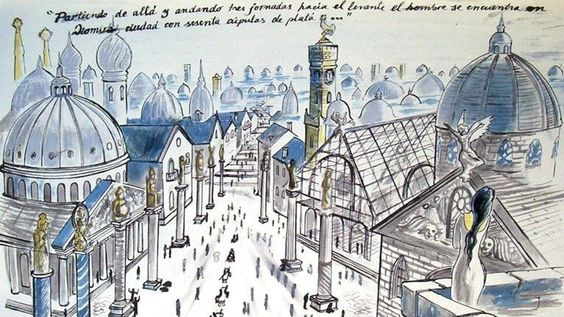

In [4]:
Image(filename='../Images/Diomira.jpg') 

## Purpose

Load the information on Geometry and Sensors from the pyTNT and make a simple display

In [5]:
import matplotlib.pyplot as plt

In [6]:
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

(0, 10)

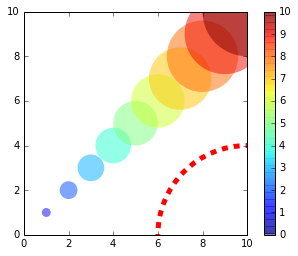

In [7]:
plt.figure(figsize=(6,4))
ax = plt.subplot(aspect='equal')

#plot a set of circle
a = arange(11)
out = circles(a, a, a*0.2, c=a, alpha=0.5, ec='none')
plt.colorbar()

#plot one circle (the lower-right one)
circles(1, 0, 0.4, 'r', ls='--', lw=5, fc='none', transform=ax.transAxes)

xlim(0,10)
ylim(0,10)

In [8]:
path='/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/'

In [9]:
ffile="WF_Tl_0.h5"

In [10]:
import pandas as pd

In [11]:
import tables as tb

In [12]:
def fill_data_(row):
    data ={}
    pos = row['position']
    data['channel'] =row['channel']
    data['x']= pos[0]
    data['y'] =pos[1]
    return data
    
def read_dataPMT ():
    with tb.open_file(path+ffile, "r") as h5in:
        #geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        PMT={}
        SIPM={}
        i=0
        for row in pmt_t.iterrows():
            PMT[i]=fill_data_(row)
            i+=1
        i=0
        for row in sipm_t.iterrows():
            SIPM[i]=fill_data_(row)
            i+=1
    return pd.DataFrame(PMT),pd.DataFrame(SIPM)

In [13]:
pmtdf,sipmdf =read_dataPMT ()

In [14]:
pmtdf

,0,1,2,3,4,5,6,7,8,9,10,11
channel,0.0000,1.0000,2.0000,3.0,5.000,6.0000,8.000,9.0000,10.0000,12.000,13.0000,14.000
x,23.9414,-68.9365,44.9951,0.0,-118.916,-182.1890,-160.215,-63.2737,63.2737,160.215,182.1890,118.916
y,65.7785,-12.1554,-53.6231,185.0,141.718,32.1249,-92.500,-173.8430,-173.8430,-92.500,32.1249,141.718


In [15]:
pmtdf.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')

In [16]:
sipmdf

,0,1,2,3,4,5,6,7,8,9,...,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790
channel,1001.0,1002.0,1003.0,1004.0,1005.0,1006.0,1007.0,1008.0,1009.0,1010.0,...,28054.0,28055.0,28056.0,28057.0,28058.0,28059.0,28060.0,28061.0,28062.0,28063.0
x,235.0,235.0,235.0,235.0,235.0,235.0,235.0,225.0,225.0,225.0,...,-225.0,-225.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0
y,55.0,65.0,75.0,85.0,95.0,105.0,115.0,45.0,55.0,65.0,...,-55.0,-45.0,-115.0,-105.0,-95.0,-85.0,-75.0,-65.0,-55.0,-45.0


In [17]:
len(pmtdf.columns)

12

In [18]:
len(sipmdf.columns)

1791

In [19]:
def sensor_energy(event_number,pmtdf,sipmdf):
    """
    Open the pyTNT, loads the pmtrd_ extensible array with 
    PMT waveforms and computes the energy of the waveforms of each PMT and SiPM.
    """
    with tb.open_file(path+ffile, "r") as h5in:
        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd
        enePMT = np.zeros(len(pmtdf.columns), dtype=np.float64)
        eneSIPM = np.zeros(len(sipmdf.columns), dtype=np.float64)
        for j in range(len(pmtdf.columns)):
            pmtrd = pmtrd_[event_number, j]
            enePMT[j] = sum(pmtrd)
        for j in range(len(sipmdf.columns)):
            sipmrd = sipmrd_[event_number, j]
            eneSIPM[j] = sum(sipmrd)
        
    pmtdf.ix['pes'] =enePMT 
    sipmdf.ix['pes'] =eneSIPM 
        

In [20]:
sensor_energy(0,pmtdf,sipmdf)

In [21]:
pmtdf

,0,1,2,3,4,5,6,7,8,9,10,11
channel,0.0000,1.0000,2.0000,3.0,5.000,6.0000,8.000,9.0000,10.0000,12.000,13.0000,14.000
x,23.9414,-68.9365,44.9951,0.0,-118.916,-182.1890,-160.215,-63.2737,63.2737,160.215,182.1890,118.916
y,65.7785,-12.1554,-53.6231,185.0,141.718,32.1249,-92.500,-173.8430,-173.8430,-92.500,32.1249,141.718
pes,4123.0000,4081.0000,4001.0000,3522.0,3365.000,3428.0000,3349.000,3405.0000,3460.0000,3453.000,3416.0000,3439.000


In [22]:
sipmdf

,0,1,2,3,4,5,6,7,8,9,...,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790
channel,1001.0,1002.0,1003.0,1004.0,1005.0,1006.0,1007.0,1008.0,1009.0,1010.0,...,28054.0,28055.0,28056.0,28057.0,28058.0,28059.0,28060.0,28061.0,28062.0,28063.0
x,235.0,235.0,235.0,235.0,235.0,235.0,235.0,225.0,225.0,225.0,...,-225.0,-225.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0,-235.0
y,55.0,65.0,75.0,85.0,95.0,105.0,115.0,45.0,55.0,65.0,...,-55.0,-45.0,-115.0,-105.0,-95.0,-85.0,-75.0,-65.0,-55.0,-45.0
pes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
x = sipmdf.ix['pes']

In [24]:
e = [ene for ene in x if ene > 0]

In [25]:
e

[4.0,
 2.0,
 85.0,
 35.0,
 5.0,
 1.0,
 326.0,
 150.0,
 29.0,
 1.0,
 2.0,
 13.0,
 6.0,
 51.0,
 110.0,
 19.0,
 145.0,
 372.0,
 13.0,
 127.0,
 309.0,
 351.0,
 169.0,
 28.0,
 2.0,
 2.0,
 21.0,
 68.0,
 94.0,
 49.0,
 10.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0]

In [26]:
def plot_sensor(sdf, rd):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    x =[]
    y =[]
    r =[]
    col = []
    for i in sdf.columns:
        sensor = sdf[i]
        x.append(sensor['x'])
        y.append(sensor['y'])
        r.append(rd)
        col.append(sensor['pes'])
    circles(x, y, r, c=col, alpha=0.5, ec='none')
    plt.colorbar()
    xlim(-198,198)
    ylim(-198,198)

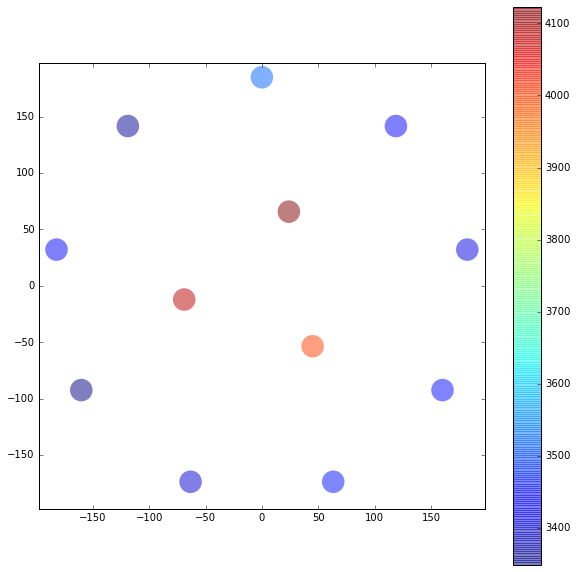

In [27]:
plot_sensor(pmtdf,10)

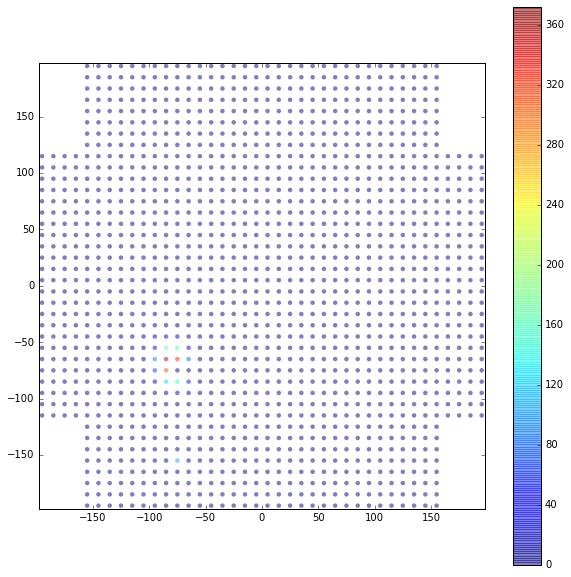

In [28]:
plot_sensor(sipmdf,2)

In [37]:
def get_mctrk(event_number):
    with tb.open_file(path+ffile, "r") as h5in:
        table = h5in.root.MC.MCTracks
        mcparticle ={}
        mc_name = []
        mc_pdg = []
        mc_vxi = []
        mc_vxf= []
        mc_nhits= []
        mc_energy= []
        for row in table.iterrows():
            if row['hit_indx'] == 0 and row['event_indx'] == event_number:
                mc_name.append(row['particle_name'])
                mc_pdg.append(row['pdg_code'])
                mc_vxi.append(row['initial_vertex'])
                mc_vxf.append(row['final_vertex'])
                mc_nhits.append(row['nof_hits'])
                mc_energy.append(row['energy']*1000.) #keV
                
        mcparticle['name'] = mc_name
        mcparticle['pdg'] = mc_pdg
        mcparticle['vxi'] = mc_vxi
        mcparticle['vxf'] = mc_vxf
        mcparticle['nhits'] = mc_nhits
        mcparticle['energy'] = mc_energy
                
    return pd.DataFrame(mcparticle)

In [39]:
d = get_mctrk(1)

In [50]:
d

,energy,name,nhits,pdg,vxf,vxi
0,179.568017,e-,35,11,"[174.971476165, 96.1616396873, 157.393478783]","[184.970198334, 71.4494559449, 143.630297656]"


In [41]:
def get_mctrks(events):
    """
    events is a list of events
    """
    particles={}
    for event_number in events:
        particles[event_number] = get_mctrk(event_number)
    
    return pd.Panel(particles)

In [42]:
particles = get_mctrks(range(5))

In [43]:
particles

<class 'pandas.core.panel.Panel'>
Dimensions: 5 (items) x 4 (major_axis) x 6 (minor_axis)
Items axis: 0 to 4
Major_axis axis: 0 to 3
Minor_axis axis: energy to vxi

In [52]:
p4 = particles[4]

In [53]:
p4

,energy,name,nhits,pdg,vxf,vxi
0,4.7747,gamma,1,22,"[-91.7288507214, -57.2155661466, 526.622584315]","[335.000928345, 0.000977546307804, 154.997920193]"
1,5.1039,gamma,1,22,"[-94.7197420096, -55.4346557024, 523.715747939]","[-91.7288507214, -57.2155661466, 526.622584315]"
2,24.6774,e-,3,11,"[-94.7068595507, -55.4060300505, 523.73806981]","[-94.7197420096, -55.4346557024, 523.715747939]"
3,155.42,e-,24,11,"[-91.0979780848, -58.0400670565, 526.954036123]","[-91.7288507214, -57.2155661466, 526.622584315]"


In [54]:
def get_hits_from_mctrk(event_number, mctrk_indx):
    with tb.open_file(path+ffile, "r") as h5in:
        table = h5in.root.MC.MCTracks
        hits ={}
        hit_position = []
        hit_time = []
        hit_energy = []
        
        for row in table.iterrows():
            if row['mctrk_indx'] == mctrk_indx and row['event_indx'] == event_number:
                hit_position.append(row['hit_position'])
                hit_time.append(row['hit_time'])
                hit_energy.append(row['hit_energy']*1000.)
                
                
        hits['pos'] =  hit_position
        hits['time'] = hit_time
        hits['energy'] = hit_energy
        
    return pd.DataFrame(hits)

In [60]:
hits = get_hits_from_mctrk(0, 3)

In [61]:
hits

,energy,pos,time
0,11.901321,"[-78.6673902196, -83.9916700364, 435.728653285]",3.176249e+11
1,7.936826,"[-78.5846518141, -83.9128322859, 435.755175786]",3.176249e+11
2,8.078063,"[-78.5864321294, -83.8447406106, 435.806383099]",3.176249e+11
3,14.635672,"[-78.6104195074, -83.8735375812, 435.765447091]",3.176249e+11
4,10.969299,"[-78.6026313257, -83.8646503627, 435.774178972]",3.176249e+11


In [57]:
get_mctrk(0)

,energy,name,nhits,pdg,vxf,vxi
0,4.774700,gamma,1,22,"[-78.6447609135, -84.148639062, 435.656932212]","[335.00167281, 0.000530810736745, 155.001130238]"
1,0.208370,gamma,1,22,"[-81.1953589556, -70.1171057574, 439.550167343]","[-78.6447609135, -84.148639062, 435.656932212]"
2,29.572930,e-,4,11,"[-81.2524533114, -70.1302910991, 439.571996596]","[-81.1953589556, -70.1171057574, 439.550167343]"
3,53.521181,e-,5,11,"[-78.6026313257, -83.8646503627, 435.774178972]","[-78.6447609135, -84.148639062, 435.656932212]"


In [63]:
mctrkp =get_mctrks(range(99))

In [66]:
mctrkp[0].dropna()

,energy,name,nhits,pdg,vxf,vxi
0,4.7747,gamma,1,22,"[-78.6447609135, -84.148639062, 435.656932212]","[335.00167281, 0.000530810736745, 155.001130238]"
1,0.20837,gamma,1,22,"[-81.1953589556, -70.1171057574, 439.550167343]","[-78.6447609135, -84.148639062, 435.656932212]"
2,29.5729,e-,4,11,"[-81.2524533114, -70.1302910991, 439.571996596]","[-81.1953589556, -70.1171057574, 439.550167343]"
3,53.5212,e-,5,11,"[-78.6026313257, -83.8646503627, 435.774178972]","[-78.6447609135, -84.148639062, 435.656932212]"


In [68]:
mctrkp.shape[0]

99

In [108]:
def get_particle_energy(mctrkp,pdg):
    """
    mctrkp is a panel
    """
    energy=[]
    
    for i in range(mctrkp.shape[0]):
        mcdf =mctrkp[i].dropna()
        for r in mcdf.itertuples():
            if r[4] == pdg:
                energy.append(r[1])
           
    return pd.Series(energy)

In [80]:
mcdf =mctrkp[0].dropna()

In [86]:
mcdf

,energy,name,nhits,pdg,vxf,vxi
0,4.7747,gamma,1,22,"[-78.6447609135, -84.148639062, 435.656932212]","[335.00167281, 0.000530810736745, 155.001130238]"
1,0.20837,gamma,1,22,"[-81.1953589556, -70.1171057574, 439.550167343]","[-78.6447609135, -84.148639062, 435.656932212]"
2,29.5729,e-,4,11,"[-81.2524533114, -70.1302910991, 439.571996596]","[-81.1953589556, -70.1171057574, 439.550167343]"
3,53.5212,e-,5,11,"[-78.6026313257, -83.8646503627, 435.774178972]","[-78.6447609135, -84.148639062, 435.656932212]"


In [94]:
for r in mcdf.itertuples():
    print(r[1])

4.7747
0.20837
29.57293
53.5211814866


In [88]:
for r in mcdf.iterrows():
    print(r)

(0, energy                                              4.7747
name                                                 gamma
nhits                                                    1
pdg                                                     22
vxf         [-78.6447609135, -84.148639062, 435.656932212]
vxi       [335.00167281, 0.000530810736745, 155.001130238]
Name: 0, dtype: object)
(1, energy                                            0.20837
name                                                gamma
nhits                                                   1
pdg                                                    22
vxf       [-81.1953589556, -70.1171057574, 439.550167343]
vxi        [-78.6447609135, -84.148639062, 435.656932212]
Name: 1, dtype: object)
(2, energy                                            29.5729
name                                                   e-
nhits                                                   4
pdg                                                    11
vxf   

In [110]:
ee = get_particle_energy(mctrkp,11)

(array([ 157.,   35.,   14.,    3.,    2.,    5.,    1.,    2.,    1.,
           0.,    0.,    2.,    1.,    2.,    0.,    0.,    0.,    0.,
           0.,    1.]),
 array([  1.69955444e-01,   9.42011961e+01,   1.88232437e+02,
          2.82263677e+02,   3.76294918e+02,   4.70326159e+02,
          5.64357399e+02,   6.58388640e+02,   7.52419880e+02,
          8.46451121e+02,   9.40482362e+02,   1.03451360e+03,
          1.12854484e+03,   1.22257608e+03,   1.31660732e+03,
          1.41063856e+03,   1.50466981e+03,   1.59870105e+03,
          1.69273229e+03,   1.78676353e+03,   1.88079477e+03]),
 <a list of 20 Patch objects>)

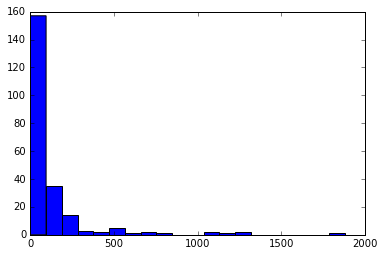

In [113]:
plt.hist(ee, 20, histtype='bar')

In [114]:
ee = get_particle_energy(mctrkp,22)

(array([ 86.,   0.,  60.,  29.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([  1.09600000e-02,   1.73821200e+00,   3.46546400e+00,
          5.19271600e+00,   6.91996800e+00,   8.64722000e+00,
          1.03744720e+01,   1.21017240e+01,   1.38289760e+01,
          1.55562280e+01,   1.72834800e+01,   1.90107320e+01,
          2.07379840e+01,   2.24652360e+01,   2.41924880e+01,
          2.59197400e+01,   2.76469920e+01,   2.93742440e+01,
          3.11014960e+01,   3.28287480e+01,   3.45560000e+01]),
 <a list of 20 Patch objects>)

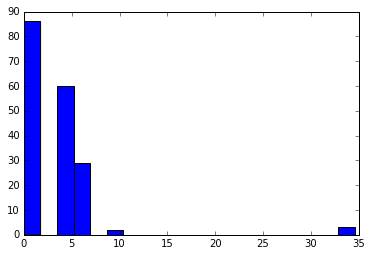

In [115]:
plt.hist(ee, 20, histtype='bar')

In [116]:
mctrkp[1].dropna()

,energy,name,nhits,pdg,vxf,vxi
0,179.568,e-,35,11,"[174.971476165, 96.1616396873, 157.393478783]","[184.970198334, 71.4494559449, 143.630297656]"


In [117]:
hits = get_hits_from_mctrk(1, 0)

In [118]:
hits

,energy,pos,time
0,3.448689,"[183.741550486, 72.4666882764, 143.715284868]",2.381449e+11
1,16.908388,"[182.841623678, 72.8851847238, 143.636357591]",2.381449e+11
2,3.611632,"[182.005217475, 73.399937464, 143.523778203]",2.381449e+11
3,3.551515,"[181.172065295, 73.9361102894, 143.515112803]",2.381449e+11
4,13.887693,"[180.305698463, 74.4082977523, 143.619047954]",2.381449e+11
5,2.647559,"[179.477620344, 74.9640429518, 143.669979307]",2.381449e+11
6,5.358025,"[178.874426678, 75.7477671515, 143.68735679]",2.381449e+11
7,8.402702,"[178.306553598, 76.5526196016, 143.768914121]",2.381449e+11
8,7.993711,"[177.680500343, 77.2725032791, 144.058118227]",2.381449e+11
9,13.572074,"[177.144649841, 77.9322026851, 144.575259308]",2.381449e+11
